In [3]:
import numpy as np
import pandas as pd
from time import time
import os
from sklearn.preprocessing import StandardScaler
from matplotlib import pyplot as plt

%matplotlib inline
plt.rcParams['figure.figsize'] = (20,15) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'
plt.style.use('ggplot')


# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

In [4]:
movies = pd.read_csv('Assignment3_Dataset/movies_metadata.csv')

#retain numeric columns for clustering
movies = movies[['budget','popularity','revenue','runtime','vote_average','vote_count']]

# drop rows with null or NaN values
movies = movies[~movies.isnull().any(axis=1)]
movies = movies.dropna()

# remove movies with less than 30 votes
movies = movies[movies['vote_count'] > 30]
movies.head()

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3146: DtypeWarning: Columns (10) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


budget popularity      revenue  runtime  vote_average  vote_count
0  30000000    21.9469  373554033.0     81.0           7.7      5415.0
1  65000000    17.0155  262797249.0    104.0           6.9      2413.0
2         0    11.7129          0.0    101.0           6.5        92.0
3  16000000    3.85949   81452156.0    127.0           6.1        34.0
4         0    8.38752   76578911.0    106.0           5.7       173.0

In [57]:
scaler = StandardScaler()
movies_standardized = scaler.fit_transform(movies.values)

## 13. Interpret the clusters based on the features used for clustering. For example, how is the cluster size related to the features (revenue, vote_count, etc.)?

The number of cluster in this dataset is highly dependent on the 4 data cluster lie on the correlated line between vote_count-revenue, budget-revenue, vote_count-budget and vote_count-popularity as shown in 

In [34]:
movies.columns

Index(['budget', 'popularity', 'revenue', 'runtime', 'vote_average',
       'vote_count'],
      dtype='object')

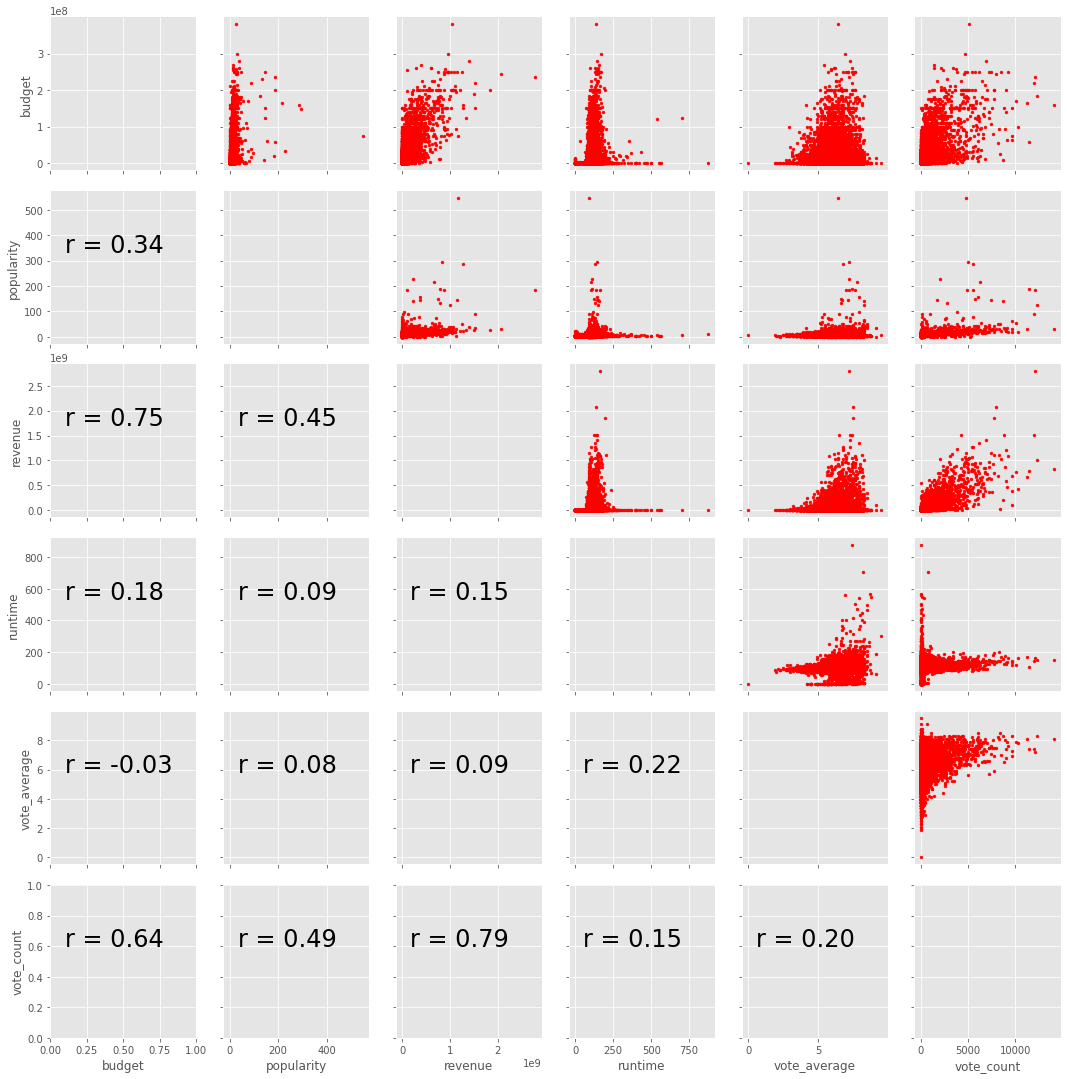

In [35]:
#Generate pair plot
import seaborn as sns
from scipy import stats

# Calculate correlation coefficient
def corrfunc(x, y, **kws):
    r, _ = stats.pearsonr(x, y)
#     print('r', r)
    ax = plt.gca()
    ax.annotate("r = {:.2f}".format(r),
                xy=(.1, .6), xycoords=ax.transAxes,
               size = 24)
    
cmap = sns.cubehelix_palette(light=1, dark = 0.1,
                             hue = 0.5, as_cmap=True)

sns.set_context(font_scale=2)

# Pair grid set up
g = sns.PairGrid(movies.astype(float))

# Scatter plot on the upper triangle
g.map_upper(plt.scatter, s=8, color = 'red')

# Correlation coefficients on the lower triangle
g.map_lower(corrfunc)

## 14. Use sklearn‚Äôs DBSCAN model to find optimal number of clusters.

In [58]:
import copy
X = copy.deepcopy(movies_standardized)

### Find Optimal Params

In [61]:
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score

In [69]:

dbscan = DBSCAN(eps=0.1, min_samples=4, metric='euclidean')
pred = dbscan.fit_predict(X)
# Sanity check: The labels of all the instances are now available in the labels_ instance variable.
np.unique(dbscan.labels_)


array([ -1,   0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,
        12,  13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,
        25,  26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,
        38,  39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,
        51,  52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,
        64,  65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,
        77,  78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,
        90,  91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102,
       103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115,
       116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128,
       129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141,
       142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154,
       155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167,
       168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 17

In [71]:
#Sanity check
silhouette_score(X, dbscan.labels_)

-0.47437783299860686

In [75]:
eps = [0.1, 1.0, 2.0, 3.5, 5.0, 10.0]
min_samples = [4, 9, 15, 30, 50]
distance_metric = ['euclidean', 'manhattan']

dbscan_basket = []
best_param, best_score, best_labels = None, -1., []

In [80]:
for e in eps:
    for ms in min_samples:
        for dm in distance_metric:
            dbscan = DBSCAN(eps=e, min_samples=ms, metric=dm)
            dbscan.fit(X)
            num_labels = np.unique(dbscan.labels_).shape[0]
            if num_labels < 2: continue
            sil = silhouette_score(X, dbscan.labels_)
            params = {
                'eps': e,
                'min_samples': ms,
                'distance_metric': dm,
                'num_labels': num_labels,
                'silhouette': sil
            }

            dbscan_basket.append(params)
            if sil > best_score:
                best_param = params
                best_score = sil
                best_labels = labels

In [173]:
#sanity check
best_param

{'eps': 10.0,
 'min_samples': 4,
 'distance_metric': 'euclidean',
 'num_labels': 2,
 'silhouette': 0.9428480074887184}

In [177]:
dbscan_basket.sort(key=lambda x: float(x['silhouette']), reverse=True)
table = {
    'eps':[],
    'min_samples':[],
    'distance_metric':[],
    'num_labels':[],
    'silhouette': []
}

for k, v in table.items():
    table[k] = [row[k] for row in dbscan_basket]

df = pd.DataFrame(table)
pd.set_option('display.max_rows', None, 'display.max_columns', None)
df

eps  min_samples distance_metric  num_labels  silhouette
0   10.0            4       euclidean           2    0.942848
1   10.0            7       euclidean           2    0.942848
2   10.0            9       euclidean           2    0.942848
3   10.0           15       euclidean           2    0.928442
4   10.0           30       euclidean           2    0.915008
5   10.0           50       euclidean           2    0.915008
6   10.0            7       manhattan           2    0.895011
7   10.0            9       manhattan           2    0.895011
8   10.0           15       manhattan           2    0.895011
9    5.0            7       euclidean           2    0.893464
10  10.0           30       manhattan           2    0.893464
11   5.0            9       euclidean           2    0.892338
12  10.0           50       manhattan           2    0.892124
13   5.0           15       euclidean           2    0.891092
14   5.0           30       euclidean           2    0.888065
15   5.0           50       euclidean           2    0.880363
16   3.5            4       euclidean           2    0.879356
17   3.5            7       euclidean           2    0.875243
18   3.5            9       euclidean           2    0.875243
19   3.5           15       euclidean           2    0.871189
20   5.0            4       euclidean           3    0.859094
21   3.5           30       euclidean           2    0.858520
22   5.0            4       manhattan           2    0.857291
23  10.0            4       manhattan           3    0.856339
24   5.0            7       manhattan           2    0.853094
25   5.0            9       manhattan           2    0.852188
26   3.5           50       euclidean           2    0.846122
27   5.0           15       manhattan           2    0.845503
28   5.0           30       manhattan           2    0.831202
29   2.0            4       euclidean           2    0.826361
30   5.0           50       manhattan           2    0.819158
31   2.0            9       euclidean           2    0.810576
32   3.5            9       manhattan           2    0.800789
33   2.0           15       euclidean           2    0.799445
34   2.0            7       euclidean           3    0.792615
35   3.5           15       manhattan           2    0.792100
36   2.0           30       euclidean           2    0.787113
37   3.5           30       manhattan           2    0.780120
38   2.0           50       euclidean           2    0.778361
39   3.5           50       manhattan           2    0.773819
40   3.5            4       manhattan           4    0.769461
41   3.5            7       manhattan           3    0.757241
42   2.0            9       manhattan           2    0.717000
43   1.0            7       euclidean           2    0.713726
44   1.0            9       euclidean           2    0.702263
45   2.0           15       manhattan           2    0.699948
46   1.0           15       euclidean           2    0.687014
47   2.0           30       manhattan           2    0.677874
48   1.0           30       euclidean           2    0.666687
49   2.0           50       manhattan           2    0.663868
50   1.0           50       euclidean           2    0.649353
51   2.0            7       manhattan           3    0.617991
52   1.0            4       euclidean           6    0.566489
53   2.0            4       manhattan          10    0.562096
54   1.0            9       manhattan           2    0.520263
55   1.0           15       manhattan           2    0.494553
56   1.0           30       manhattan           2    0.449506
57   1.0           50       manhattan           2    0.426957
58   1.0            7       manhattan           4    0.156463
59   1.0            4       manhattan          16    0.127959
60   0.1            4       euclidean         181   -0.474378
61   0.1            4       euclidean         181   -0.474378
62   0.1            4       euclidean         181   -0.474378
63   0.1            4       euclidean

# Part C: Outlier Detection


In [5]:
sports = pd.read_csv('Assignment3_Dataset/NHL-2003-2004.csv')

In [6]:
sports.columns

Index(['Player', 'Season', 'Team', 'S/C', 'Pos', 'GP', 'G', 'A', 'P', '+/-',
       'PIM', 'P/GP', 'EVG', 'EVP', 'PPG', 'PPP', 'SHG', 'SHP', 'GWG', 'S',
       'S%', 'TOI/GP', 'FOW%'],
      dtype='object')

In [7]:
sports.head()

Player    Season Team S/C Pos  GP   G   A   P  +/-  ...  EVP  \
0  Martin St. Louis  20032004  TBL   L   R  82  38  56  94   35  ...   53   
1    Ilya Kovalchuk  20032004  ATL   R   L  81  41  46  87  -10  ...   52   
2         Joe Sakic  20032004  COL   L   C  81  33  54  87   11  ...   49   
3    Markus Naslund  20032004  VAN   L   L  78  35  49  84   24  ...   58   
4      Marian Hossa  20032004  OTT   L   R  81  36  46  82    4  ...   42   

   PPG  PPP  SHG  SHP  GWG    S    S%  TOI/GP  FOW%  
0    8   30    8   11    7  212  17.9   20:35  33.3  
1   16   33    1    2    6  341    12   23:06  32.1  
2   13   37    1    1    3  253    13   20:16  52.6  
3    5   26    0    0    6  296  11.8   19:23  35.7  
4   14   39    1    1    5  233  15.4   18:37    40  

[5 rows x 23 columns]

## 1. Display the dimension of data (no. of rows and columns)

In [8]:
sports.shape

(916, 23)

## 2.The shooting percentage (S%) column might have rows with non-numeric values such as "--". Replace those values by 0.0. You may use DataFrame‚Äôs ‚Äúreplace‚Äù method.

In [9]:
sports1 = sports[['GP', 'G', 'S%']].replace('--', 0.0).astype(float)
sports2 = sports[['P', '+/-', 'PIM']].replace('--', 0.0).astype(float)
sports1.replace('')
sports1.head()

GP     G    S%
0  82.0  38.0  17.9
1  81.0  41.0  12.0
2  81.0  33.0  13.0
3  78.0  35.0  11.8
4  81.0  36.0  15.4

## 3. Create data matrix from the DataFrame object. Note that we don‚Äôt have the data labels. Create two data matrices (X1 and X2) by using feature set 1 and feature set 2, respectively. Thus, X1 and X2 should have 3 columnsindependently

In [10]:
X1, X2 = sports1.values, sports2.values

In [11]:
import numpy as np
from sklearn.neighbors import LocalOutlierFactor

## 4. Local Outlier Factor: You will useScikit-Learn‚Äôs Local Outlier Factor modelfor this task. Findan optimal value forùëò(number of nearest neighbors) based on the technique described in the notebook on Local Outlier Factor (https://github.com/rhasanbd/Local-Outlier-Factor-Effective-Technique-for-Ranking-Outliers). Briefly, vary theùëòbetween a minimum and a maximum value, and compute LOF values for each data point in that range. Then, choose the max LOF value for each data point from that range.


$$
k_{min} = 40 \\
k_{max} = 55 
$$

Optimal k range on X1 dataset = **[43, 44, 45, 46, 47, 48, 49, 50, 51]**

According to heuristic for selecting the range for k, min k is selected by counting minimal cluster size which consist of similar behaving point. Max k is selected by considering maximum number of objects that we want to be outliers if clustered together.

In general, LOF > 1 is used to identify outliers but since  the X1 dataset is sparse, varying density, with many local fluctuation specific to that local cluster, we conclude that datapoint with LOF value > 3. would consider to be an outlier. After filtering out all the LOF values of all datapoint based on the anomaly LOF values, we notice that when k is less than 43 or greater than 51, all datapoint have similar LOG values. when k is in between 43 and 51, the distance points (738th, 742th, 745th) in X1 have much small LOF value. Thus, LOF algorithm successfully detected 3 outliers for k in between 43 and 51.

 
Optimal k range on X2 dataset = **[51, 52, 53, 54, 55]**

Similarly, the same procedure is applied to find optimal k value on X2 dataset. when k is in between 51 and 55, LOF is varied between 2.5 and 3.0. Since the dataset is tight, clean and uniform, the LOF value of around 2.5 were picked as a threshold to determin optimal k.

In [12]:
def compute_negative_lof_mat(X, k_list):
    negative_lof_matrix = np.ones((X.shape[0], len(k_list))) * 99999

    for i in range(len(k_list)):
        lof = LocalOutlierFactor(n_neighbors=k_list[i], algorithm='auto', contamination='auto', n_jobs=-1)
        lof.fit(X)

        # store the negative LOF values in the matrix
        for j in range(len(lof.negative_outlier_factor_)):
            negative_lof_matrix[j, i] = lof.negative_outlier_factor_[j]
    return negative_lof_matrix

def visualize_lof_mat(negative_lof_matrix, k_list):
    print("Negative LOF Matrix: from k = %d to k = %d" % (k_list[0], k_list[len(k_list)-1]))

    datapoint_ids = np.arange(0, negative_lof_matrix.shape[0])

    column_names = [_ for _ in k_list]
    row_names = [_ for _ in datapoint_ids]
    lof_df = pd.DataFrame(np.around(negative_lof_matrix,2), index=row_names, columns=column_names)
    return lof_df



import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

def plot_scatter3d_abnomaly(_df, anomaly_index, columns=[]):
    fig = plt.figure()
    ax = fig.gca(projection='3d')
    ax.scatter(_df[columns[0]], _df[columns[1]], _df[columns[2]], facecolors='yellow', alpha=.30, s=100)
    ax.set_xlabel(columns[0])
    ax.set_ylabel(columns[1])
    ax.set_zlabel(columns[2])

    ax.scatter(_df.iloc[anomaly_index][columns[0]],
               _df.iloc[anomaly_index][columns[1]],
               _df.iloc[anomaly_index][columns[2]],
               color="black", alpha=.8)

### For X1

In [143]:
k_min, k_max = 40, 55
k_list = np.arange(k_min, k_max+1)

X1_negative_lof_matrix = compute_negative_lof_mat(X1, k_list)

In [144]:
visualize_lof_mat(X1_negative_lof_matrix, k_list)

Negative LOF Matrix: from k = 40 to k = 55


40    41    42    43    44    45    46    47    48    49    50    51  \
0   -1.57 -1.55 -1.57 -1.59 -1.59 -1.61 -1.62 -1.63 -1.64 -1.64 -1.65 -1.65   
1   -1.75 -1.74 -1.76 -1.77 -1.78 -1.80 -1.81 -1.81 -1.80 -1.81 -1.81 -1.82   
2   -1.28 -1.29 -1.30 -1.30 -1.31 -1.32 -1.32 -1.32 -1.32 -1.32 -1.32 -1.32   
3   -1.40 -1.38 -1.38 -1.38 -1.38 -1.39 -1.40 -1.41 -1.41 -1.42 -1.42 -1.42   
4   -1.45 -1.45 -1.44 -1.45 -1.46 -1.45 -1.46 -1.47 -1.46 -1.47 -1.47 -1.47   
..    ...   ...   ...   ...   ...   ...   ...   ...   ...   ...   ...   ...   
911 -1.00 -1.00 -1.00 -1.00 -1.00 -1.00 -1.00 -1.00 -1.00 -1.00 -1.00 -1.00   
912 -1.14 -1.14 -1.15 -1.15 -1.17 -1.20 -1.19 -1.19 -1.19 -1.29 -1.29 -1.29   
913 -1.04 -1.04 -1.04 -1.05 -1.05 -1.10 -1.11 -1.11 -1.12 -1.11 -1.12 -1.13   
914 -1.06 -1.06 -1.06 -1.06 -1.06 -1.05 -1.06 -1.06 -1.05 -1.05 -1.05 -1.05   
915 -0.99 -0.98 -0.98 -0.97 -0.97 -1.03 -1.03 -1.03 -1.03 -1.04 -1.04 -1.04   

       52    53    54    55  
0   -1.65 -1.66 -1.66 -1.67  
1   -1.83 -1.83 -1.84 -1.84  
2   -1.32 -1.32 -1.33 -1.33  
3   -1.42 -1.43 -1.43 -1.44  
4   -1.47 -1.48 -1.48 -1.49  
..    ...   ...   ...   ...  
911 -1.00 -1.00 -1.00 -1.00  
912 -1.10 -1.10 -1.10 -1.10  
913 -1.13 -1.13 -1.14 -1.14  
914 -1.05 -1.05 -1.05 -1.05  
915 -1.03 -1.03 -1.03 -1.03  

[916 rows x 16 columns]

In [145]:
# find min lof score for each k among datapoints
X1_negative_lof_matrix.min(axis=0)

array([-6.93336803, -7.01772256, -7.09824351, -7.17649895, -7.26147869,
       -6.66904146, -6.69846864, -6.72509301, -6.75986297, -6.78968575,
       -6.82661764, -6.87030942, -6.44690432, -6.490548  , -6.44466682,
       -6.44441655])

In [181]:
#select a reasonable threshold (-6.0) to mask out outliers datapoint
X1_LOF_THRESHOLD = -6.
x1_mask = X1_negative_lof_matrix * (X1_negative_lof_matrix < X1_LOF_THRESHOLD)

In [182]:
#mask out those outlier ids
X1_outlier_ids = np.where(x1_mask.sum(axis=1) != 0.)[0]
X1_outlier_ids

array([738, 742, 745])

In [183]:
# determine the range 
optimal_k_range = np.where((X1_negative_lof_matrix[X1_outlier_ids] < X1_LOF_THRESHOLD).sum(axis=0) >= 3)[0] + k_min
optimal_k_range

array([43, 44, 45, 46, 47, 48, 49, 50, 51])

### For X2

In [149]:
k_min, k_max = 40, 55
k_list = np.arange(k_min, k_max+1)

X2_negative_lof_matrix = compute_negative_lof_mat(X2, k_list)
visualize_lof_mat(X2_negative_lof_matrix, k_list)

Negative LOF Matrix: from k = 40 to k = 55


40    41    42    43    44    45    46    47    48    49    50    51  \
0   -1.81 -1.82 -1.83 -1.84 -1.85 -1.85 -1.87 -1.87 -1.87 -1.87 -1.86 -1.87   
1   -1.42 -1.42 -1.42 -1.42 -1.43 -1.42 -1.43 -1.43 -1.43 -1.44 -1.45 -1.45   
2   -1.34 -1.35 -1.34 -1.34 -1.35 -1.35 -1.36 -1.36 -1.36 -1.36 -1.36 -1.37   
3   -1.35 -1.35 -1.36 -1.36 -1.35 -1.34 -1.35 -1.34 -1.34 -1.34 -1.35 -1.35   
4   -1.26 -1.26 -1.27 -1.27 -1.27 -1.28 -1.27 -1.28 -1.27 -1.28 -1.28 -1.28   
..    ...   ...   ...   ...   ...   ...   ...   ...   ...   ...   ...   ...   
911 -1.38 -1.39 -1.41 -1.42 -1.43 -1.43 -1.41 -1.42 -1.41 -1.24 -1.23 -1.25   
912 -1.05 -1.05 -1.06 -1.08 -1.08 -1.10 -1.09 -1.08 -1.08 -1.13 -1.13 -1.14   
913 -1.41 -1.40 -1.40 -1.40 -1.41 -1.41 -1.41 -1.43 -1.43 -1.33 -1.33 -1.33   
914 -1.15 -1.15 -1.15 -1.15 -1.15 -1.15 -1.15 -1.15 -1.14 -1.15 -1.15 -1.15   
915 -1.01 -1.01 -1.01 -1.03 -1.03 -1.05 -1.05 -1.05 -1.05 -1.05 -1.06 -1.07   

       52    53    54    55  
0   -1.87 -1.88 -1.88 -1.88  
1   -1.44 -1.44 -1.44 -1.44  
2   -1.36 -1.36 -1.37 -1.37  
3   -1.35 -1.36 -1.36 -1.36  
4   -1.28 -1.28 -1.29 -1.28  
..    ...   ...   ...   ...  
911 -1.25 -1.19 -1.19 -1.19  
912 -1.14 -1.07 -1.08 -1.08  
913 -1.33 -1.28 -1.30 -1.29  
914 -1.15 -1.14 -1.14 -1.15  
915 -1.07 -1.07 -1.08 -1.08  

[916 rows x 16 columns]

In [150]:
# find min lof score for each k among datapoints
X2_negative_lof_matrix.min(axis=0)

array([-2.88397674, -2.95251592, -3.01604714, -2.96088978, -2.94369769,
       -2.94329705, -2.91718783, -2.88586352, -2.89807297, -2.92106714,
       -2.94050856, -2.94414943, -2.95950934, -2.97749379, -2.99937377,
       -3.01154567])

In [220]:
X2_LOG_THRESHOLD = -2.77

In [221]:
#select a reasonable threshold to mask out outliers datapoint
x2_mask = X2_negative_lof_matrix * (X2_negative_lof_matrix < X2_LOG_THRESHOLD)

#mask out those outlier ids
X2_outlier_ids = np.where(x2_mask.sum(axis=1) != 0.)[0]
X2_outlier_ids

array([243, 248, 589, 598, 746])

In [153]:
X2_negative_lof_matrix[X2_outlier_ids]

array([[-2.65531525, -2.66431256, -2.64583344, -2.66103072, -2.65114144,
        -2.6708332 , -2.6886345 , -2.70233235, -2.72781641, -2.74856656,
        -2.74732292, -2.7575685 , -2.77216623, -2.78941269, -2.81050104,
        -2.82248202],
       [-2.879405  , -2.86686766, -2.86437067, -2.84316302, -2.83121058,
        -2.8486785 , -2.8712748 , -2.88586352, -2.89807297, -2.92106714,
        -2.94050856, -2.94414943, -2.95950934, -2.97749379, -2.99937377,
        -3.01154567],
       [-2.88397674, -2.95251592, -3.01604714, -2.96088978, -2.94369769,
        -2.94329705, -2.91718783, -2.88527633, -2.86088627, -2.67804646,
        -2.68041684, -2.66845278, -2.71544848, -2.73933319, -2.7748945 ,
        -2.80512453],
       [-2.575616  , -2.59150268, -2.59619629, -2.61707787, -2.60756445,
        -2.63207387, -2.6622448 , -2.67866878, -2.70559136, -2.72210462,
        -2.73942763, -2.75668773, -2.75586136, -2.77505494, -2.76133874,
        -2.74475611],
       [-2.43397054, -2.41719034, -2

In [154]:
X2_negative_lof_matrix[X2_outlier_ids] < X2_LOG_THRESHOLD

array([[False, False, False, False, False, False, False, False, False,
        False, False,  True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True,  True,  True,  True,  True,
        False, False, False, False, False,  True,  True],
       [False, False, False, False, False, False, False, False, False,
        False, False,  True,  True,  True,  True, False],
       [False, False, False, False, False, False, False, False, False,
        False, False, False,  True, False,  True,  True]])

In [155]:
from scipy import stats 
pd.DataFrame(X2_negative_lof_matrix).describe()

0           1           2           3           4           5   \
count  916.000000  916.000000  916.000000  916.000000  916.000000  916.000000   
mean    -1.138418   -1.140410   -1.141908   -1.143597   -1.145546   -1.147235   
std      0.219815    0.222675    0.224290    0.226086    0.227701    0.230546   
min     -2.883977   -2.952516   -3.016047   -2.960890   -2.943698   -2.943297   
25%     -1.186579   -1.192090   -1.197190   -1.197247   -1.202698   -1.203299   
50%     -1.057064   -1.055989   -1.056820   -1.057896   -1.057630   -1.058470   
75%     -1.011438   -1.011128   -1.011979   -1.011932   -1.013354   -1.013705   
max     -0.960441   -0.959886   -0.959038   -0.955982   -0.954336   -0.953443   

               6           7           8           9           10          11  \
count  916.000000  916.000000  916.000000  916.000000  916.000000  916.000000   
mean    -1.148101   -1.149048   -1.150441   -1.141531   -1.143087   -1.144546   
std      0.231163    0.232387    0.234033    0.223866    0.225991    0.227257   
min     -2.917188   -2.885864   -2.898073   -2.921067   -2.940509   -2.944149   
25%     -1.203061   -1.206377   -1.208515   -1.195407   -1.198396   -1.199707   
50%     -1.058581   -1.061266   -1.061716   -1.062578   -1.063725   -1.065930   
75%     -1.011742   -1.011261   -1.012065   -1.012990   -1.013146   -1.012980   
max     -0.962089   -0.966352   -0.970394   -0.970450   -0.973014   -0.972513   

               12          13          14          15  
count  916.000000  916.000000  916.000000  916.000000  
mean    -1.145176   -1.142771   -1.144352   -1.145625  
std      0.228586    0.226894    0.228759    0.230556  
min     -2.959509   -2.977494   -2.999374   -3.011546  
25%     -1.199679   -1.193064   -1.191796   -1.193576  
50%     -1.067179   -1.065132   -1.066256   -1.067417  
75%     -1.013374   -1.013247   -1.013413   -1.013470  
max     -0.971985   -0.975893   -0.974723   -0.973996

## 5 + 6. Using max LOF values for each data pointidentify the first 3~5 outliers both for feature set 1 and feature set 2. You may vary model parametersto optimize your results,if necessary. Justify result

### Feature set #1

As shown in experiment below, datapoint 712th, 738th, 742th, 743th and 745th are detected by LOF algorithm as anomaly with three top worth highlighting anomaly 712th, 738th, and 742th. The same characteristic that.listed anomaly has in common is extremely low gameplayed, goals scored values and high shooting percentage. Intuitively, this is expected as in most hockey league, the number of gameplayed should be proportional to shoot percentage indicate that the play play well and are given many opportunity to make a strike. The 3 anomaly datapoint went against with gameplayed-shooting percentage proportionality logic thus, algorithm detected it in the low density area.

Datapoint #743, #745 is also classified as anomaly due to its extremely low gameplayed and goal score values. In real life, this incident rarely happen because professional league often optimize there budget and hire well played hockey player to play often through out the league. These 2 incident indicate that there number of gameplayed, shooting percentage and goal scored is same. This can be interpret as luck. 

In [27]:
sports1.describe()

GP           G          S%
count  916.000000  916.000000  916.000000
mean    48.378821    6.896288    7.253057
std     28.737165    8.108765    7.568007
min      1.000000    0.000000    0.000000
25%     18.000000    1.000000    1.800000
50%     57.000000    4.000000    6.600000
75%     75.000000   11.000000   10.900000
max     83.000000   41.000000  100.000000

In [28]:
X1_outlier_ids

array([712, 738, 742, 743, 745])

In [29]:
sports1.iloc[X1_outlier_ids]

GP    G     S%
712  4.0  1.0   50.0
738  3.0  1.0  100.0
742  2.0  1.0  100.0
743  1.0  1.0   25.0
745  4.0  1.0   10.0

#### VIsualize Outliers on Feature Set #1

In [191]:
sports1

eps                       10
min_samples                4
distance_metric    euclidean
num_labels                 2
silhouette          0.942848
Name: 0, dtype: object

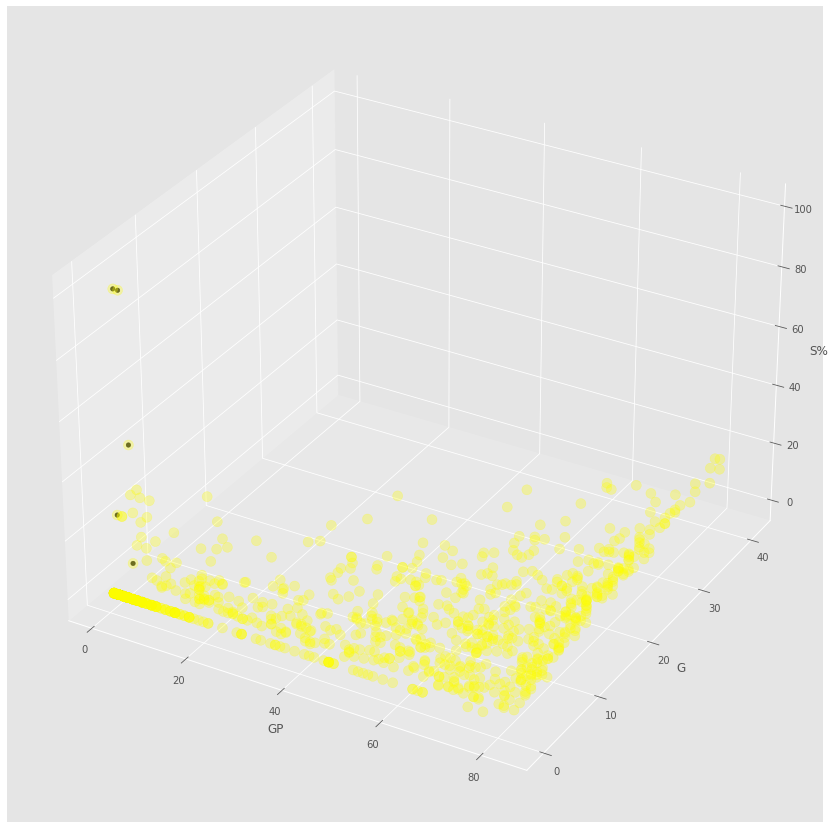

In [156]:
plot_scatter3d_abnomaly(sports1, X1_outlier_ids, ['GP', 'G', 'S%'])

### Feature set #2

The algorithm classified datapoint as anomaly based on 2 category of logic. 

1. moderate point scored, moderate plus-minus statistic, and high penalty-minute values (243th, 248th, and 598)
2. moderate point scored, moderate plus-minus statistic, and low penalty-minute values (589th, 746th)

Intuitively, this is expected as moderated point-scored, moderate plus-minus(game impact) player are well trained and know the rule well so they should be expected to have small number of penalty in a game. Since well played player are often have high number of game played, they are expected to have more conflict thus the number of of penalty should be moderate.


Note: Moderate means near expectation value and within 1 std.


In [157]:
sports2.describe()

P         +/-         PIM
count  916.000000  916.000000  916.000000
mean    18.579694   -0.284934   38.791485
std     19.256372    9.914974   39.623683
min      0.000000  -46.000000    0.000000
25%      2.750000   -5.250000   10.000000
50%     12.000000   -1.000000   26.000000
75%     29.000000    4.000000   54.250000
max     94.000000   35.000000  261.000000

In [158]:
X2_outlier_ids

array([243, 248, 589, 598, 746])

In [159]:
sports2.iloc[X2_outlier_ids]

P   +/-    PIM
243  28.0  15.0  250.0
248  28.0   2.0  261.0
589   6.0   5.0    0.0
598   5.0  -8.0  247.0
746   1.0  -9.0    0.0

#### Visualize Outliers on Feature set #2

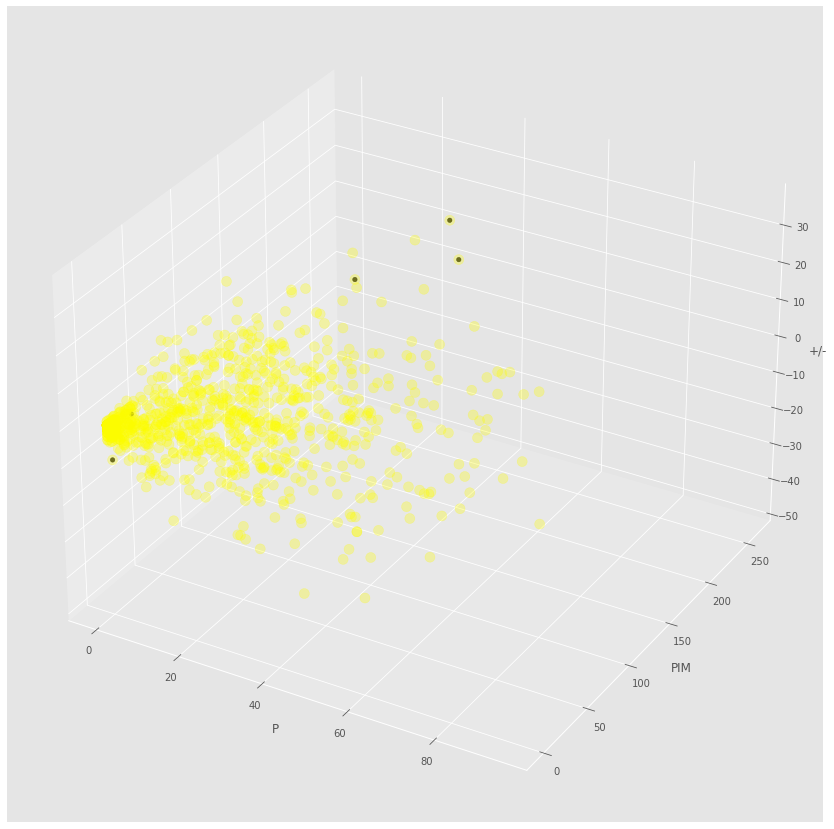

In [222]:
plot_scatter3d_abnomaly(sports2, X2_outlier_ids, ['P', 'PIM', '+/-'])

## 7 + 8. Isolation Forest: Using Scikit-Learn‚Äôs Isolation Forestobjectidentify the first 3~5 outliers both for feature set 1 and feature set 2. You may vary model parameters to optimize your results, if necessary. Interpret your results.

In [162]:
from sklearn.ensemble import IsolationForest

In [163]:
sports1_iso = sports1.copy()

In [164]:
%time

#n_estimators: # of tree
iso_forest = IsolationForest(n_estimators=256, max_samples='auto', contamination=0.005,
                    max_features=1.0, bootstrap=False, verbose=1, n_jobs=-1, random_state=42, behaviour="new")

tic = time()
iso_forest.fit(sports1_iso)
toc = time()
toc - tic

CPU times: user 2 ¬µs, sys: 1e+03 ns, total: 3 ¬µs
Wall time: 4.77 ¬µs


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/ensemble/_iforest.py:255: FutureWarning: 'behaviour' is deprecated in 0.22 and will be removed in 0.24. You should not pass or set this parameter.
  FutureWarning
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done   2 out of  16 | elapsed:    0.4s remaining:    2.6s
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.4s finished


0.532397985458374

In [165]:
sports1_iso['iso_scores'] = iso_forest.decision_function(X1)
sports1_iso['anomaly'] = iso_forest.predict(X1)

In [166]:
anomaly=sports1_iso.loc[sports1_iso['anomaly']==-1]
anomaly_index=list(anomaly.index)
anomaly

GP    G     S%  iso_scores  anomaly
510  15.0  5.0   31.3   -0.007376       -1
693   4.0  2.0   33.3   -0.001697       -1
712   4.0  1.0   50.0   -0.002249       -1
738   3.0  1.0  100.0   -0.076697       -1
742   2.0  1.0  100.0   -0.078487       -1

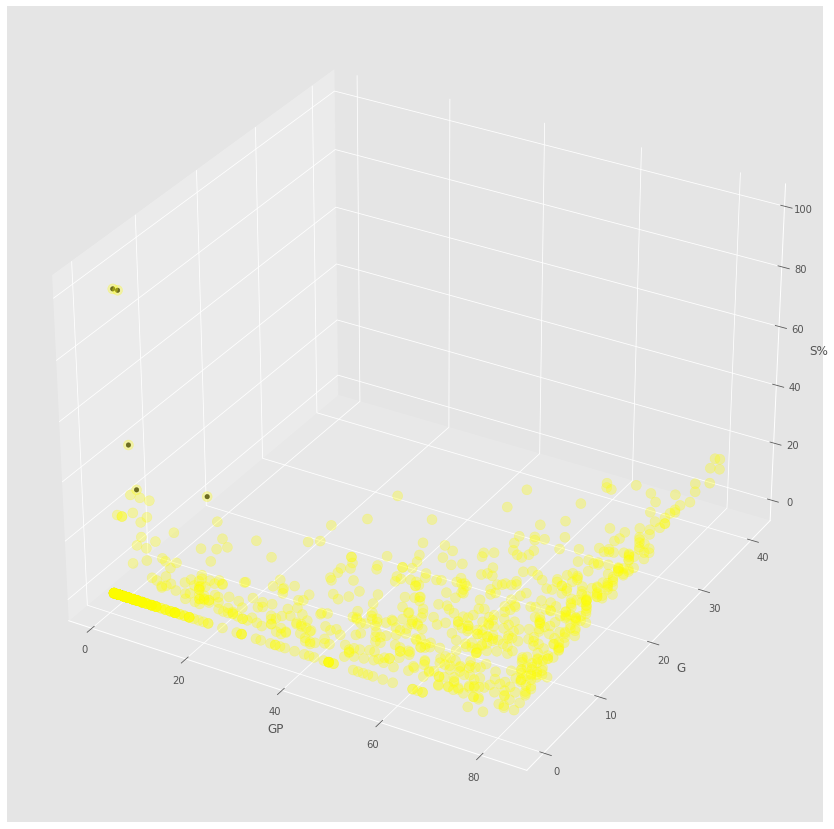

In [168]:
plot_scatter3d_abnomaly(sports1_iso, anomaly_index, ['GP', 'G', 'S%'])

### Feature set #2

In [169]:
sports2_iso = sports2.copy()

iso_forest2 = IsolationForest(n_estimators=256, max_samples='auto', contamination=0.005,
                    max_features=1.0, bootstrap=False, verbose=1, n_jobs=-1, random_state=42, behaviour="new")

tic = time()
iso_forest2.fit(sports2_iso)

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/ensemble/_iforest.py:255: FutureWarning: 'behaviour' is deprecated in 0.22 and will be removed in 0.24. You should not pass or set this parameter.
  FutureWarning
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done   2 out of  16 | elapsed:    0.4s remaining:    2.7s
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.4s finished


IsolationForest(behaviour='new', contamination=0.005, n_estimators=256,
                n_jobs=-1, random_state=42, verbose=1)

In [170]:
sports2_iso['iso_scores'] = iso_forest2.decision_function(X2)
sports2_iso['anomaly'] = iso_forest2.predict(X2)

In [171]:
anomaly2=sports2_iso.loc[sports2_iso['anomaly']==-1]
anomaly2_index=list(anomaly2.index)
anomaly2

P   +/-    PIM  iso_scores  anomaly
0    94.0  35.0   24.0   -0.054908       -1
40   57.0 -35.0   87.0   -0.001272       -1
132  41.0  33.0  147.0   -0.023050       -1
243  28.0  15.0  250.0   -0.022179       -1
248  28.0   2.0  261.0   -0.011315       -1

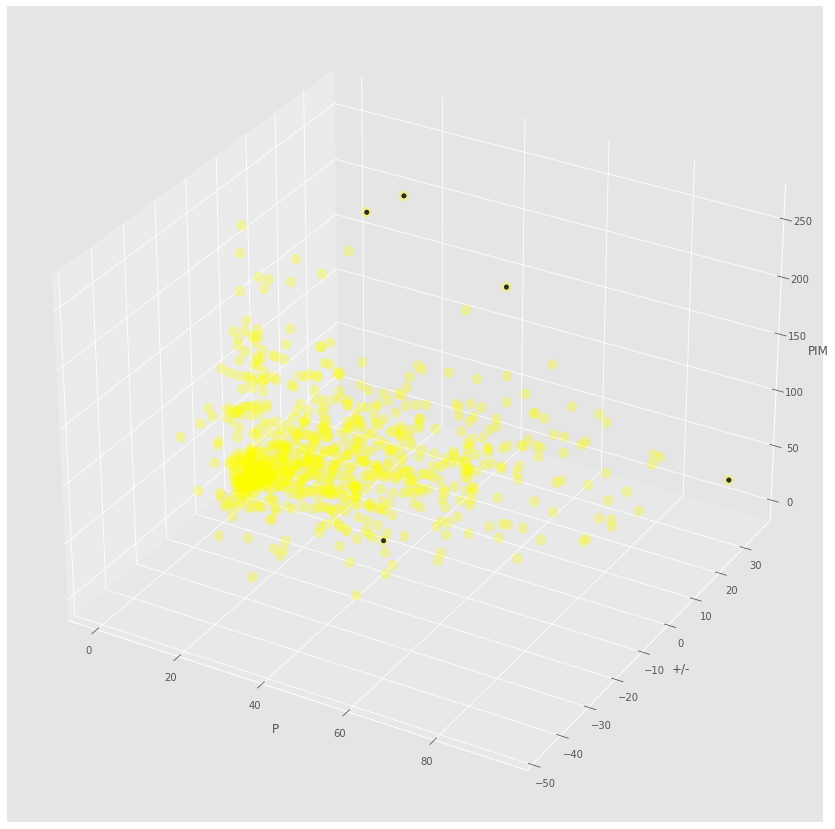

In [172]:
plot_scatter3d_abnomaly(sports2_iso, anomaly2_index, ['P', '+/-', 'PIM'])

## 9. Compare the results obtained from Local Outlier Factor and Isolation Forest.Which technique you think performed better and why?


Visually, isolation forest model is more sensitive to global outlier as shown in picture showing anomaly in feature set #2. anomaly lie in the low density with extreme feature values. Technically speaking, this is expected as the algorithm try to create multiple decision branch base on a common mean values therefore, exceptionally low and high values will be detected and classified in the sparse branch region.

In case of LOF, the algorithm has advantage due to the local aspect of LOF, meaning hthat it only compares the score of anomality of one sample with the score of its neighbors.

Depend on the application, isolation forest can be chosen over LOF where global anomaly is more interested over local


# Perform outlier detection on the same dataset for both feature sets using sklearn‚Äôs Gaussian Mixture Model (GMM)object

In [54]:
from sklearn.mixture import GaussianMixture

def find_optimal_k_BIC_AIC(X_mat, neighbors_range = np.arange(1,21)):
    gms_per_k = [GaussianMixture(n_components=k, n_init=10, random_state=42).fit(X1)
                 for k in neighbors_range]
    bics = [model.bic(X1) for model in gms_per_k]
    aics = [model.aic(X1) for model in gms_per_k]

    # Find the value of "k" that gives minimum BIC
    j = 0
    min_bic = bics[j]
    max_k = 1

    for i in neighbors_range:
        if(bics[j] < min_bic):
            min_bic = bics[j]
            max_k = i
        j +=1
    return max_k


def plot_BIC_AIC_values(bics, aics):
    plt.figure(figsize=(12, 6))
    plt.plot(range(1, 21), bics, "bo-", label="BIC")
    plt.plot(range(1, 21), aics, "go--", label="AIC")
    plt.xlabel("$k$", fontsize=14)
    plt.ylabel("Information Criterion", fontsize=14)
    plt.legend()
    plt.show()

 ## 10. Find an optimal number of components using Bayesian information criterion (BIC) andAkaike information criterion (AIC) using GMM 
## 11. Using the optimal number of components identify the first 3~5 outliers both for feature set 1 and feature set 2. You may vary model parameters to optimize your results, if necessary. 
## 12. Interpret result

GMM is a Gaussian based model meaning each datapoint is evaluated among other to find its likelihood on belonging to a cluster. Since each datapoint is falled within a smoothed Gaussian distribution, therefore, instance located in low-density region will be considered as anomaly. Visually, datapoints 3, 22, 50, 64, ... 712 lied in the low density region. Datapoint 738th and 742th, who were classified as anomaly by LFO and Isolation Forest, were not detected by GMM as anomaly. This is expected because lots of other datapoint have low GP and G values which balance out the density thus, 738th and 742th were not classified as anomaly. Same argument can be held for feature set #2

### Feature set #1

#### Find Optimal k

In [56]:
%% time 
maxk1 = find_optimal_k_BIC_AIC(X1, neighbors_range=np.arange(1, 21))

In [57]:
maxk1

17

#### GMM: Train using Optimal k

In [58]:
gmm1 = GaussianMixture(n_components=maxk1, n_init=10, random_state=42)
gmm1.fit(X1)

GaussianMixture(n_components=17, n_init=10, random_state=42)

#### Find outliers

In [61]:
densities = gmm1.score_samples(X1) 
density_threshold = np.percentile(densities, 1) #density < threshold is anomaly
abnomaly_gmm_detected_index = np.where(densities < density_threshold)[0]

In [80]:
sports1.iloc[abnomaly_gmm_detected_index]

GP     G    S%
3    78.0  35.0  11.8
22   75.0  30.0  22.1
50   39.0  18.0  21.2
64   55.0  24.0  15.0
69   45.0  19.0  14.3
87   72.0  28.0  22.6
166  59.0  24.0  22.9
521  57.0   7.0  33.3
687  29.0   2.0  28.6
712   4.0   1.0  50.0

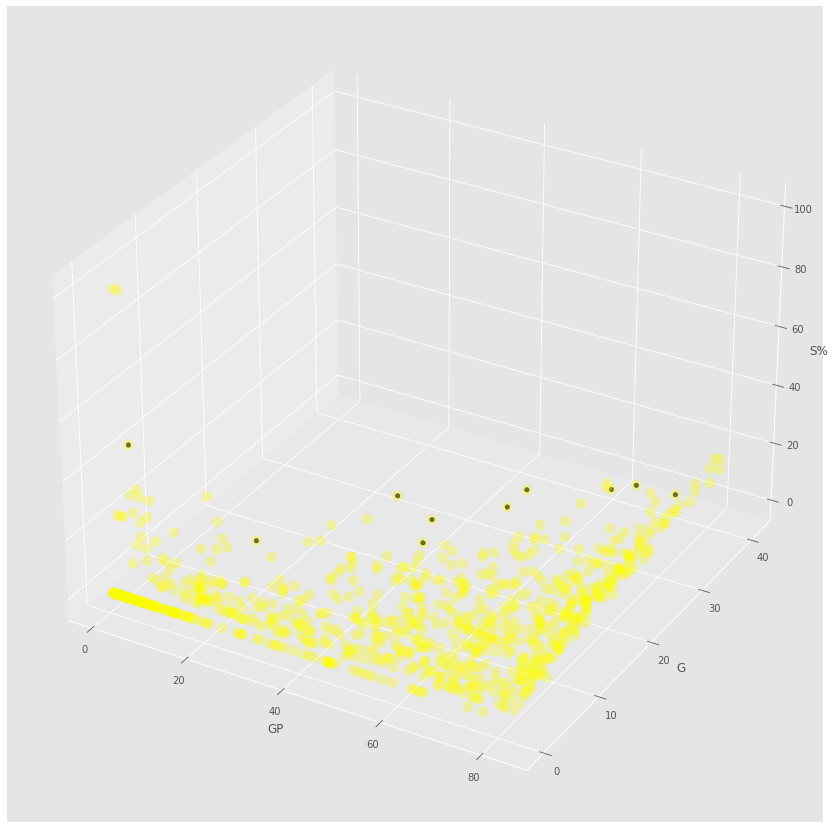

In [78]:
plot_scatter3d_abnomaly(sports1, abnomaly_gmm_detected_index, ['GP', 'G', 'S%'])

### Feature set #2

#### Find optimal K

In [69]:
%%time 
maxk2 = find_optimal_k_BIC_AIC(X2, neighbors_range=np.arange(1, 21))

CPU times: user 57.9 s, sys: 3.72 s, total: 1min 1s
Wall time: 10.4 s


In [70]:
maxk2

17

#### Train using optimal k

In [72]:
gmm2 = GaussianMixture(n_components=maxk2, n_init=10, random_state=42)
gmm2.fit(X2)

GaussianMixture(n_components=17, n_init=10, random_state=42)

#### Find Outliers

In [73]:
densities2 = gmm2.score_samples(X2) 
density_threshold2 = np.percentile(densities2, 1) #density < threshold is abnomaly
abnomaly_gmm_detected_index2 = np.where(densities2 < density_threshold2)[0]

In [81]:
sports2.iloc[abnomaly_gmm_detected_index2]

P   +/-    PIM
1    87.0 -10.0   63.0
15   73.0  21.0   84.0
24   68.0  -4.0   12.0
34   60.0  21.0  122.0
40   57.0 -35.0   87.0
174  34.0 -46.0   54.0
252  28.0 -13.0  102.0
365  19.0  35.0   45.0
474  11.0 -26.0   18.0
504  10.0 -36.0  127.0

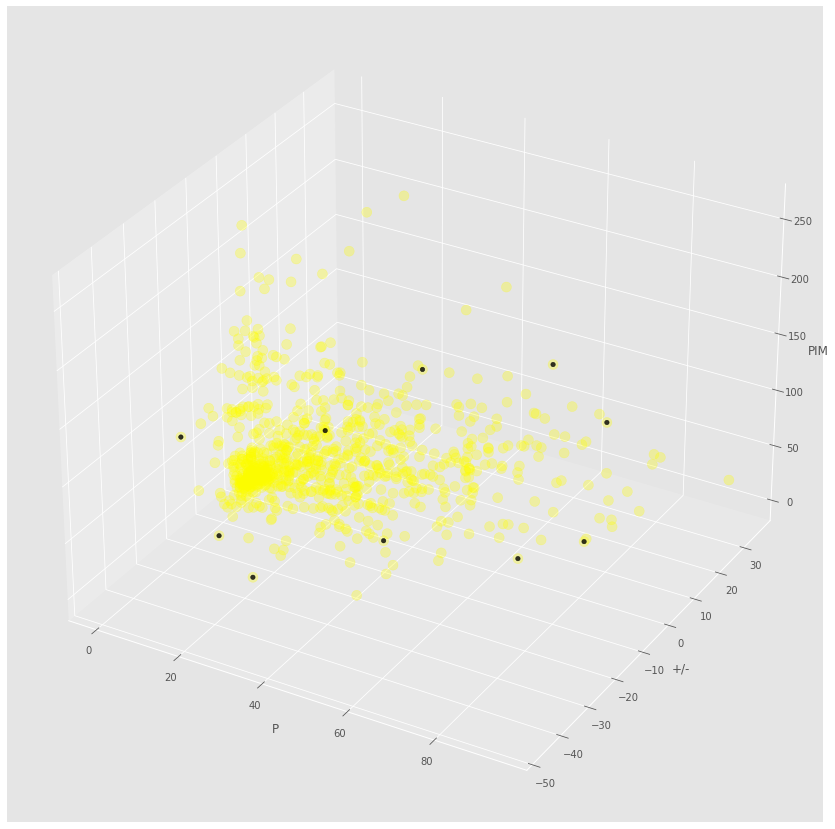

In [79]:
plot_scatter3d_abnomaly(sports2, abnomaly_gmm_detected_index2, ['P', '+/-', 'PIM'])

### 13. Compare GMM based outliers with Local Outlier Factor and Isolation Forest. Which technique you think performed better outlier detection and why?


GMM takes different approach as LOF and Isolation Forest. GMM is a generative model, aiming to learn the probablity distribution governing the dataset, while the latter is an pure outlier detection model, which rather than finding the clusters in dataset, detects outlying points. Since GMM is govern by a probability distribution, datapoint in a low threshold is classifed as anomaly. If dataset have a high dimension then value in one dimension can balance out the other thus, GMM can fail to detect such points. LOF and isolcation forest can be used as alternative.

It is challenging to call 1 model perform better than other as depending on the dataset one can be prefered over other. For application like detecting anomaly player in sport, LOF and isolation forest can be used as those player with exceptionally high and low in a score can possibly be anomaly. Overall, GMM requires significantly longer time to train, excluding the reuiqred time for optimal k selection. 